# Document Classification using RVL-CDIP


# About the author

Thomas Weikert is a MSc Autonomous System student at KTH (Stockholm) and Aalto University (Helsinki) through EIT Digital from Berlin, Germany. Before specializing in Data Science, Thomas obtained 5 years of professional experience in Corporate and Investment Banking. Realising that he was stalling his technical skills, Thomas left Finance towards Data Science to follow his passion to work on emerging technologies. More about Thomas: https://www.linkedin.com/in/weikert/

# Preface

This notebook provides the code which I used to classify four different types of documents. 

This notebook globally covers the following aspects:
- **Problem Definition:** Classification task using transfer learning
- **Exploratory Data Analysis:**  Summary of data main characteristics, using statistical graphics and other data visualization methods. 
- **Transfer Learning with imagenet initialized VGG:** Using a DCNN for problem solving. The process involves building, training and prediction.
- **Conclusion:** My main key-take-aways

Through this, the notebook gives an overview of my approach to classify different document types. Hopefully it is as informative as convincing (of my potential), and – not in the least – enthusing. Enjoy
reading!

Yours sincerely, 


Thomas

# Import 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import seaborn as sns

import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import batch_normalization
from keras.layers.convolutional import *
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model 
from tensorflow.keras.optimizers import Adam

from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Exploratory Data Analysis

In [3]:
CATEGORIES = ["email", "invoice", "letter", "cv"]
DATADIR = "/content/gdrive/MyDrive/workist_data"

In [4]:
##################################
# Check data distribusion
##################################

img_heigth = []
img_width = []
pixel_means = []

for category in CATEGORIES:  
  path = os.path.join(DATADIR,category)  # create path
  class_num = CATEGORIES.index(category)  # get the classification  (0,1,2,3). 
  for img in tqdm(os.listdir(path)):  # iterate over each image 
    img_array = cv2.imread(os.path.join(path,img))  # convert to array
    img_heigth.append(img_array.shape[0])
    img_width.append(img_array.shape[1])
    pixel_mean = np.mean(np.array(img_array))
    pixel_means.append(pixel_mean)

100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


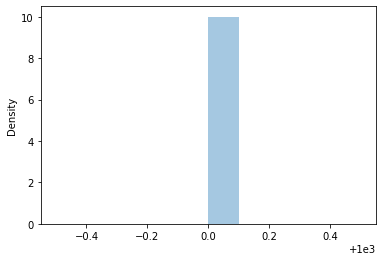

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


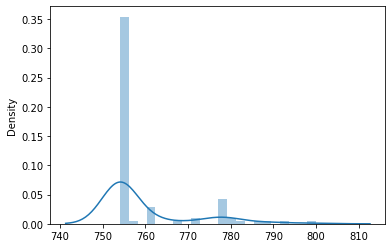

In [5]:
sns.distplot(img_heigth,kde = True) # plot density of image heigght
plt.show()

sns.distplot(img_width,kde = True) # plot density of image widths
plt.show()

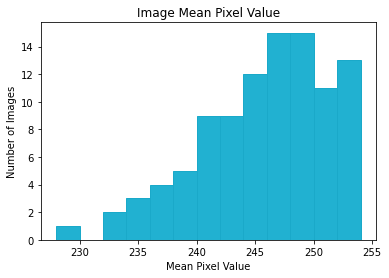

In [6]:
pixel_means_int = [int(x) for x in pixel_means]
plt.hist(pixel_means, bins = range(min(pixel_means_int), max(pixel_means_int) + 2, 2), color = '#21B1D1', edgecolor = '#1AA9C9')
plt.title('Image Mean Pixel Value')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Number of Images')
plt.show()




* All images are 1000 pixels tall
* Most are 100x752  
* The majority of images are mostly white space
  * Darkest image (230 mean value)
  * Whitest image (254 mean value) 
* There is a lot variance in the width. Therefore I rescale all imgs before feeding into neural net.
*   Classes are balanced as data set is small with 25 examples each. Therefore, I do not need to check class balance. 



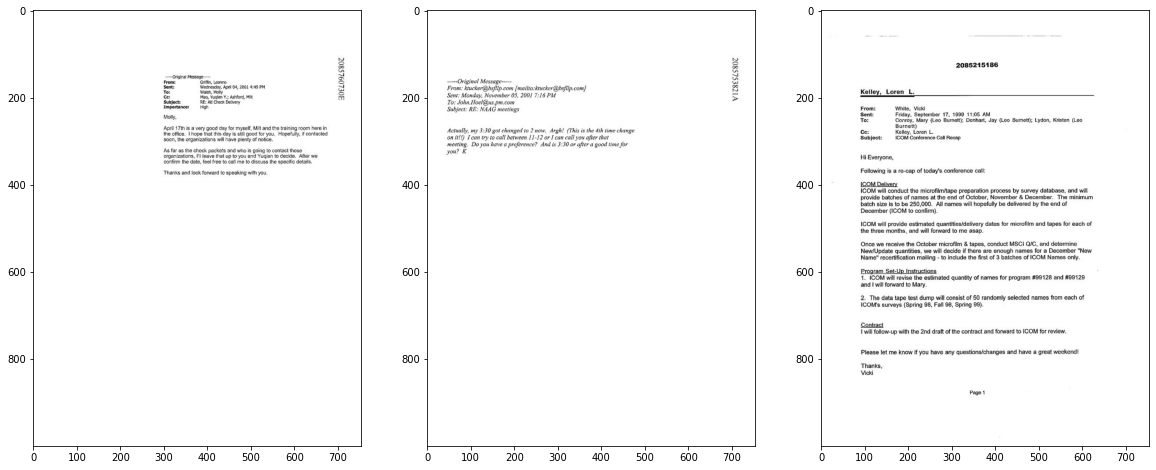

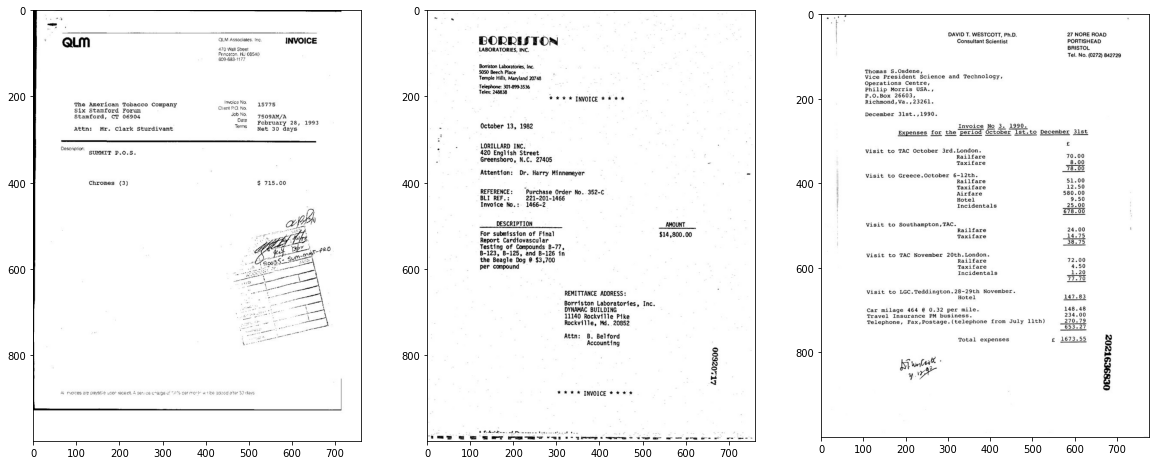

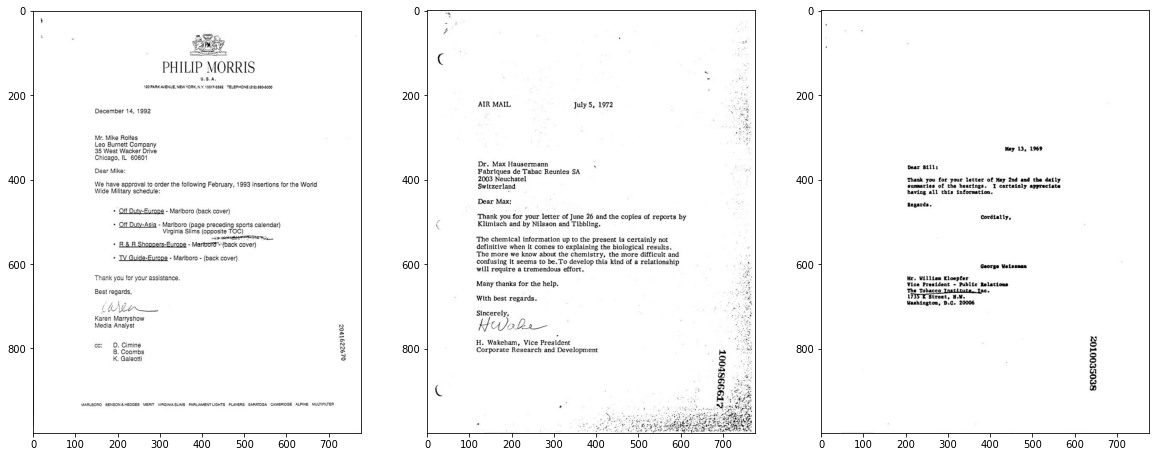

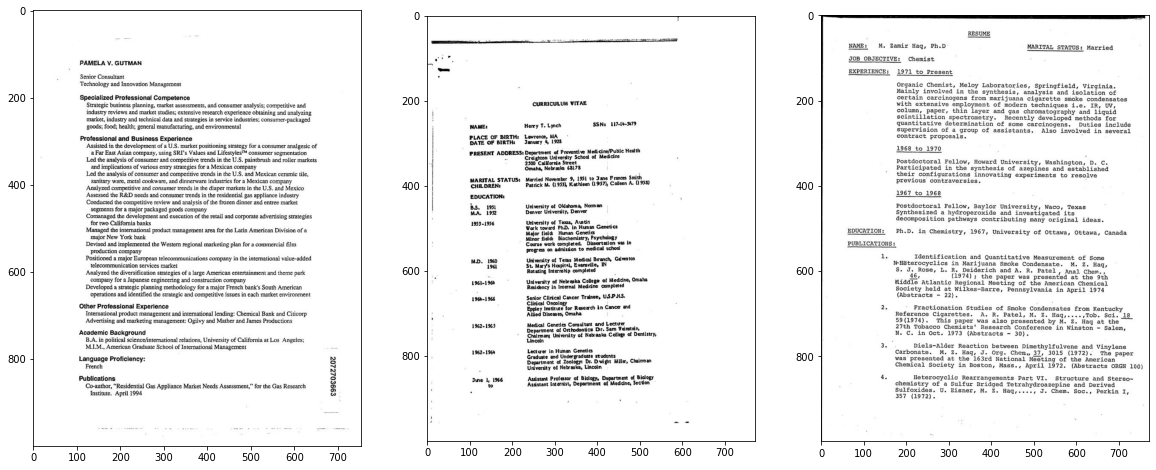

In [7]:
##################################
# Visualize documents (3 samples of each type, 4 rows for each type)
###################################
# not pretty, but fast :)

for category in CATEGORIES: 
  path = os.path.join(DATADIR,category)  
  fig,axes = plt.subplots(1, 3,figsize=(20,20))

  img_array = cv2.imread(os.path.join(path,os.listdir(path)[0]))  # convert to array
  axes[0].imshow(img_array)  # graph it

  img_array = cv2.imread(os.path.join(path,os.listdir(path)[1]))  # convert to array
  axes[1].imshow(img_array)  # graph it

  img_array = cv2.imread(os.path.join(path,os.listdir(path)[2]))  # convert to array
  axes[2].imshow(img_array)  # graph it
    

/content/gdrive/MyDrive/workist_data/email


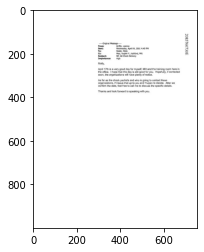

In [10]:
##################################
# Get appropiate rescaling size
###################################

for category in CATEGORIES: 
    path = os.path.join(DATADIR,category)  # create path 
    print(path)
    for img in os.listdir(path):  # iterate over each image
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array)  # graph it
        plt.show()  # display!

        break  # I just want one for now so break
    break  #...and one more!

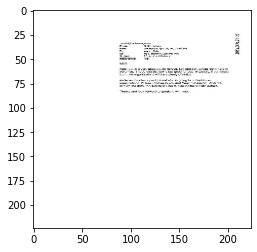

In [9]:
IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()



*   224x224 seems to be an appropiate fit for rescaling all images.


# Image preparation for VGG16 Image Classifier

**Note**
*   For training and validation purpose, the available data was split into training, validation and testing datasets. 
*   I manually organized the folder structure in GD. I am using 21 samples per class for training (84 in total), 2 samples per class for validation (8 in total) and 5 samples per class for testing (8 in total) 
*  Please note that I think the amount of data to build an accurate classifier is not enough. In general I would recommend to use the full dataset and use at least 1000 samples per class for training

**Final Dataset**
* 84 training images (21 per class)
* 8 validation images (2 per class)
* 8 testing images (2 per class)
* All images resized to 256x256 for initial analysis





**Preparation overview**

*   Create train, valid, test batches for all models
* To avoid any reseting issues of the generators, I decided to use a pipeline for each model
* Preprocessing steps:
  * convert_4darray: Function which takes images as input, rescales the images as 256x256 pixels and then converts it into a 4d array
  * The images are rescaled by dividing every pixel in every image by 255
  * Labels are one hot labeled 


In [11]:
train_path = "/content/gdrive/MyDrive/workist_data/Train"  
valid_path = "/content/gdrive/MyDrive/workist_data/Valid"  
test_path = "/content/gdrive/MyDrive/workist_data/Test"  

In [12]:
train_gen_holistic = ImageDataGenerator(rescale=1 / 255.0)
valid_gen_holistic = ImageDataGenerator(rescale=1 / 255.0)
test_gen_holistic = ImageDataGenerator(rescale=1 / 255.0)

train_gen_holistic_2 = ImageDataGenerator(rescale=1 / 255.0)
valid_gen_holistic_2 = ImageDataGenerator(rescale=1 / 255.0)
test_gen_holistic_2 = ImageDataGenerator(rescale=1 / 255.0)

train_gen_holistic_3 = ImageDataGenerator(rescale=1 / 255.0)
valid_gen_holistic_3 = ImageDataGenerator(rescale=1 / 255.0)
test_gen_holistic_3 = ImageDataGenerator(rescale=1 / 255.0)

train_gen_top = ImageDataGenerator(rescale=1 / 255.0)
valid_gen_top = ImageDataGenerator(rescale=1 / 255.0)
test_gen_top = ImageDataGenerator(rescale=1 / 255.0)

train_gen_bottom = ImageDataGenerator(rescale=1 / 255.0)
valid_gen_bottom = ImageDataGenerator(rescale=1 / 255.0)
test_gen_bottom = ImageDataGenerator(rescale=1 / 255.0)

train_gen_right = ImageDataGenerator(rescale=1 / 255.0)
valid_gen_right = ImageDataGenerator(rescale=1 / 255.0)
test_gen_right = ImageDataGenerator(rescale=1 / 255.0)

train_gen_left = ImageDataGenerator(rescale=1 / 255.0)
valid_gen_left = ImageDataGenerator(rescale=1 / 255.0)
test_gen_left = ImageDataGenerator(rescale=1 / 255.0)

In [13]:
##################################
# Create train, valid, test batches for all models
##################################

img_width, img_height = 256,256

train_batches_holistic = train_gen_holistic.flow_from_directory(train_path, target_size=(img_width, img_height) , classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
valid_batches_holistic = valid_gen_holistic.flow_from_directory(valid_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
test_batches_holistic = test_gen_holistic.flow_from_directory(test_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)  
print('#######')
train_batches_holistic_2 = train_gen_holistic_2.flow_from_directory(train_path, target_size=(img_width, img_height) , classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
valid_batches_holistic_2 = valid_gen_holistic_2.flow_from_directory(valid_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
test_batches_holistic_2 = test_gen_holistic_2.flow_from_directory(test_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)  
print('#######')
train_batches_holistic_3 = train_gen_holistic_3.flow_from_directory(train_path, target_size=(img_width, img_height) , classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
valid_batches_holistic_3 = valid_gen_holistic_3.flow_from_directory(valid_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
test_batches_holistic_3 = test_gen_holistic_3.flow_from_directory(test_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)  
print('#######')
train_batches_top = train_gen_top.flow_from_directory(train_path, target_size=(img_width, img_height) , classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
valid_batches_top = valid_gen_top.flow_from_directory(valid_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
test_batches_top = test_gen_top.flow_from_directory(test_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)  
print('#######')
train_batches_bottom = train_gen_bottom.flow_from_directory(train_path, target_size=(img_width, img_height) , classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
valid_batches_bottom = valid_gen_bottom.flow_from_directory(valid_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
test_batches_bottom = test_gen_bottom.flow_from_directory(test_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)  
print('#######')
train_batches_right = train_gen_right.flow_from_directory(train_path, target_size=(img_width, img_height) , classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
valid_batches_right = valid_gen_right.flow_from_directory(valid_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
test_batches_right = test_gen_right.flow_from_directory(test_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)  
print('#######')
train_batches_left = train_gen_left.flow_from_directory(train_path, target_size=(img_width, img_height) , classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
valid_batches_left = valid_gen_left.flow_from_directory(valid_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)
test_batches_left = test_gen_left.flow_from_directory(test_path, target_size=(img_width, img_height), classes = ["email", "invoice", "letter", "cv"], batch_size = 5)  



Found 84 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
#######
Found 84 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
#######
Found 84 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
#######
Found 84 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
#######
Found 84 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
#######
Found 84 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
#######
Found 84 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


# **Holistic VGG16 Image Classifier**

In total I am building three models:


1.   Transfer Learning with Imagenet init VGG
2.   Fine tuning last CNN layer of VGG
3.   Fine tuning last two CNN layer of VGG





# 1. ) Transfer Learning with Imagenet init VGG

In [33]:
##################################
# Init VGG16
##################################
img_width, img_height = 256,256

#holistic_model_1 = keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3),)
holistic_model_1 = keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3),)


In [35]:
for layer in holistic_model_1.layers:
  layer.trainable = True 

In [36]:
##################################
#Adding custom Layers 
##################################

x = holistic_model_1.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)


# creating the final model 
holistic_model_1_final = Model(holistic_model_1.input, predictions)

# compile the model 
holistic_model_1_final.compile(loss = "categorical_crossentropy", optimizer =Adam(lr=0.0001), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [38]:
holistic_model_1_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [40]:
holistic_model_1_final.fit_generator(
    train_batches_holistic, 
    steps_per_epoch= 4 , 
    validation_data = valid_batches_holistic,
    validation_steps= 2,
    epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/20
4/4 [==============================] - 10s 1s/step - loss: 1.7897 - accuracy: 0.2500 - val_loss: 1.3839 - val_accuracy: 0.2500
Epoch 2/20
4/4 [==============================] - 2s 430ms/step - loss: 1.4124 - accuracy: 0.2500 - val_loss: 1.2512 - val_accuracy: 0.3750
Epoch 3/20
4/4 [==============================] - 2s 434ms/step - loss: 1.2414 - accuracy: 0.3500 - val_loss: 1.0225 - val_accuracy: 0.6250
Epoch 4/20
4/4 [==============================] - 5s 2s/step - loss: 1.3072 - accuracy: 0.4211 - val_loss: 0.9622 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 2s 429ms/step - loss: 1.1487 - accuracy: 0.5500 - val_loss: 0.8600 - val_accuracy: 0.5000
Epoch 6/20
4/4 [==============================] - 2s 429ms/step - loss: 0.9792 - accuracy: 0.6500 - val_loss: 0.7568 - val_accuracy: 0.7500
Epoch 7/20
4/4 [==============================] - 2s 429ms/step - loss: 0.8533 - accuracy: 0.6500 - val_loss: 1.1167 - val_accuracy: 0.7500
Epoch 8/20
4/4 [=========

In [43]:
score=holistic_model_1_final.evaluate_generator(test_batches_holistic,steps=1,workers=2, use_multiprocessing=True, verbose=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [44]:
print("The accuracy for model-Pretrained vgg-16 initiazlied with image net:",score[1]*100,"%")


The accuracy for model-Pretrained vgg-16 initiazlied with image net: 60.00000238418579 %


# 2.) Fine tuning last CNN layer of VGG

In [45]:
holistic_model_2 = keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3),)

In [46]:
for layer in holistic_model_2.layers:
    layer.trainable=False  
holistic_model_2.layers[-2].trainable=True    

#Adding custom Layers 
x = holistic_model_2.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

# creating the final model 
holistic_model_2_final = Model(holistic_model_2.input, predictions)

# compile the model 
holistic_model_2_final.compile(loss = "categorical_crossentropy", optimizer =Adam(lr=0.0001), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [48]:
holistic_model_2_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [54]:
history = holistic_model_2_final.fit_generator(
    train_batches_holistic_2, 
    steps_per_epoch= 4 , 
    validation_data = valid_batches_holistic_2,
    validation_steps= 2,
    epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
4/4 [==============================] - 1s 275ms/step - loss: 0.2369 - accuracy: 0.9500 - val_loss: 0.5140 - val_accuracy: 0.7500
Epoch 2/20
4/4 [==============================] - 1s 237ms/step - loss: 0.2198 - accuracy: 1.0000 - val_loss: 0.5000 - val_accuracy: 0.7500
Epoch 3/20
4/4 [==============================] - 1s 239ms/step - loss: 0.2081 - accuracy: 0.8947 - val_loss: 0.4645 - val_accuracy: 0.7500
Epoch 4/20
4/4 [==============================] - 1s 238ms/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 0.3427 - val_accuracy: 0.8750
Epoch 5/20
4/4 [==============================] - 1s 240ms/step - loss: 0.2297 - accuracy: 0.9000 - val_loss: 0.3642 - val_accuracy: 0.8750
Epoch 6/20
4/4 [==============================] - 1s 235ms/step - loss: 0.1706 - accuracy: 1.0000 - val_loss: 0.4729 - val_accuracy: 0.7500
Epoch 7/20
4/4 [==============================] - 1s 236ms/step - loss: 0.0926 - accuracy: 1.0000 - val_loss: 0.5509 - val_accuracy: 0.6250
Epoch 8/20
4/4 [====

In [55]:
score=holistic_model_2_final.evaluate_generator(test_batches_holistic_2,steps=1,workers=2, use_multiprocessing=True, verbose=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [56]:
print("The accuracy for model-Pretrained vgg-16 initiazlied with image net:",score[1]*100,"%")


The accuracy for model-Pretrained vgg-16 initiazlied with image net: 100.0 %


In [57]:
import seaborn as sns
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()


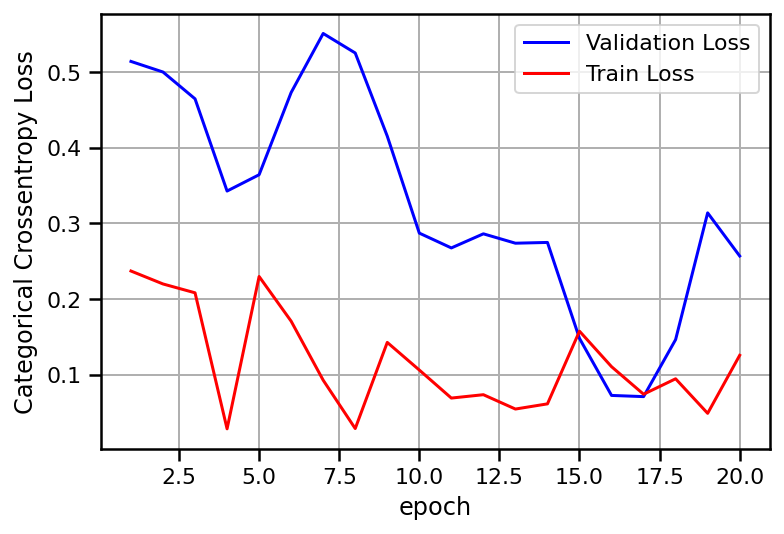

In [58]:
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,20+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# 3.) Fine tuning last two CNN layer of VGG

In [59]:
holistic_model_3 = keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3),)

In [60]:
for layer in holistic_model_2.layers:
    layer.trainable=False  
holistic_model_2.layers[-2].trainable=True
holistic_model_2.layers[-3].trainable=True      

#Adding custom Layers 
x = holistic_model_3.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

# creating the final model 
holistic_model_3_final = Model(holistic_model_3.input, predictions)

# compile the model 
holistic_model_3_final.compile(loss = "categorical_crossentropy", optimizer =Adam(lr=0.0001), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [61]:
holistic_model_3_final.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [62]:
history = holistic_model_3_final.fit_generator(
    train_batches_holistic_3, 
    steps_per_epoch= 4 , 
    validation_data = valid_batches_holistic_3,
    validation_steps= 2,
    epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
4/4 [==============================] - 4s 540ms/step - loss: 1.6812 - accuracy: 0.3500 - val_loss: 1.4056 - val_accuracy: 0.2500
Epoch 2/20
4/4 [==============================] - 2s 433ms/step - loss: 1.4946 - accuracy: 0.2500 - val_loss: 1.6743 - val_accuracy: 0.2500
Epoch 3/20
4/4 [==============================] - 2s 432ms/step - loss: 1.6491 - accuracy: 0.1000 - val_loss: 1.4462 - val_accuracy: 0.2500
Epoch 4/20
4/4 [==============================] - 2s 429ms/step - loss: 1.4681 - accuracy: 0.2000 - val_loss: 1.4072 - val_accuracy: 0.2500
Epoch 5/20
4/4 [==============================] - 2s 434ms/step - loss: 1.4730 - accuracy: 0.3500 - val_loss: 1.3625 - val_accuracy: 0.3750
Epoch 6/20
4/4 [==============================] - 2s 431ms/step - loss: 1.3005 - accuracy: 0.4500 - val_loss: 1.4163 - val_accuracy: 0.2500
Epoch 7/20
4/4 [==============================] - 2s 430ms/step - loss: 1.4913 - accuracy: 0.0500 - val_loss: 1.3947 - val_accuracy: 0.2500
Epoch 8/20
4/4 [====

In [65]:
score=holistic_model_3_final.evaluate_generator(test_batches_holistic_3,steps=1,workers=2, use_multiprocessing=True, verbose=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [66]:
print("The accuracy for model-Pretrained vgg-16 initiazlied with image net:",score[1]*100,"%")


The accuracy for model-Pretrained vgg-16 initiazlied with image net: 100.0 %


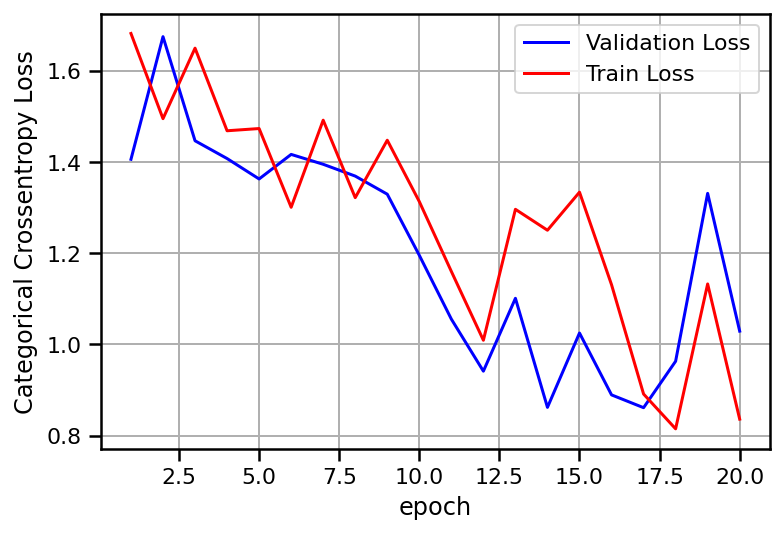

In [67]:
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,20+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Conclusion

In [69]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["MODEL","TEST ACCURACY","VAL ACCURACY"]

x.add_row(["VGG TRANSFER LEARNING WITH IMAGENET INITIALIZED WEIGHTS FINE TUNING ALL LAYERS","60,0%","75,0%"])
x.add_row(["FINE TUNING LAST LAYER OF VGG WITH IMAGENET INITIALIZED WIEGHTS","100,0%","87,5%"])
x.add_row(["FINE TUNING LAST 2 LAYER OF VGG WITH IMAGENET INITIALIZED WIEGHTS","100,0%","75,0"])

print(x)

+--------------------------------------------------------------------------------+---------------+--------------+
|                                     MODEL                                      | TEST ACCURACY | VAL ACCURACY |
+--------------------------------------------------------------------------------+---------------+--------------+
| VGG TRANSFER LEARNING WITH IMAGENET INITIALIZED WEIGHTS FINE TUNING ALL LAYERS |     60,0%     |    75,0%     |
|        FINE TUNING LAST LAYER OF VGG WITH IMAGENET INITIALIZED WIEGHTS         |     100,0%    |    87,5%     |
|       FINE TUNING LAST 2 LAYER OF VGG WITH IMAGENET INITIALIZED WIEGHTS        |     100,0%    |     75,0     |
+--------------------------------------------------------------------------------+---------------+--------------+




*   I only use 21 samples per class and I have observed that increasing the data increases the accuracy
*   I got the best model with fine tuning the last 2 layer of VGG with Imagenet Initialized weights.
* In order to further improve the accuracy I suggest to use an Intra-domain Transfer learning technique and ine tuning VGG-region specific. E.g. the first 256 pixels from top to bottom and crop the remaining. I do this by building a cropping function and passing that function to the generator.A potential architecture could look like the following chart below.




1. Top region
2. Bottom region
3. Left region
4. Right region




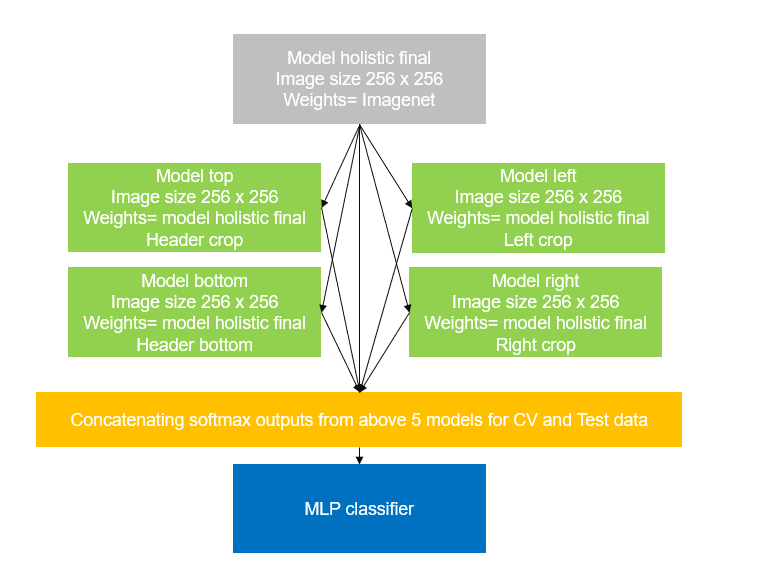


1. Top region
2. Bottom region
3. Left region
4. Right region

